## Text Summarization: Leveraging SAMSum Dialogue Dataset

#### Installing requirements

In [3]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AdamW
from rouge_score import rouge_scorer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

/.autofs/tools/spack/var/spack/environments/psyc681-23083101/.spack-env/view/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
2023-12-11 23:50:47.103182: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 23:50:47.549070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### if you get a error run the cell below

In [3]:
# ! pip3 install rouge-score wordcloud seaborn  py7zr transformers[torch] -U sentence-transformers sacrebleu

In [4]:
from datasets import load_dataset

# Load the SAMSum dataset
dataset = load_dataset("samsum")


Found cached dataset samsum (/home/ud9701/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Convert the dataset to a Pandas DataFrame for easier manipulation

train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

## EDA

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the dataset to a Pandas DataFrame for easier manipulation
# Basic info
print("Number of samples in training set:", len(train_df))
print("First few samples:\n", train_df.head())

# Data distribution
train_df['dialogue_len'] = train_df['dialogue'].str.split().str.len()
train_df['summary_len'] = train_df['summary'].str.split().str.len()

print("\nDialogue length statistics:\n", train_df['dialogue_len'].describe())
print("\nSummary length statistics:\n", train_df['summary_len'].describe())

Number of samples in training set: 14732
First few samples:
          id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\r\...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\r\nSam:...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  

Dialogue length statistics:
 count    14732.000000
mean        93.786383
std         74.033457
min          0.000000
25%         39.000000
50%         73.000000
75%        128.000000
max        803.000000
Name: 

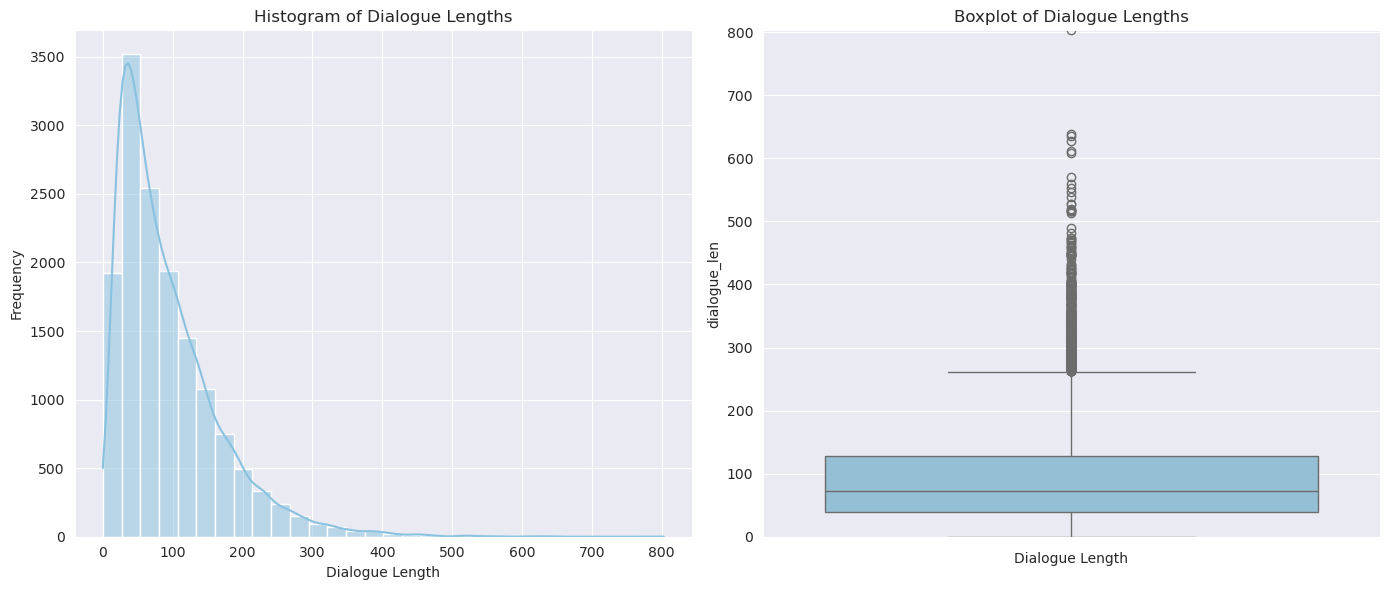

In [7]:
sns.set_style("darkgrid")

# Define color for the dialogue plots
dialogue_color = "#89c2e0"

# Dialogue Length Distribution
plt.figure(figsize=(14, 6))

# Histogram for Dialogue Lengths
plt.subplot(1, 2, 1)
sns.histplot(train_df['dialogue_len'], bins=30, kde=True, color=dialogue_color)
plt.title('Histogram of Dialogue Lengths')
plt.xlabel('Dialogue Length')
plt.ylabel('Frequency')

# Boxplot for Dialogue Lengths
plt.subplot(1, 2, 2)
sns.boxplot(train_df['dialogue_len'], color=dialogue_color)
plt.title('Boxplot of Dialogue Lengths')
plt.xlabel('Dialogue Length')
# Set y-axis limit to ignore extreme outliers for better visualization
plt.ylim(0, train_df['dialogue_len'].quantile(1))

plt.tight_layout()
plt.show()

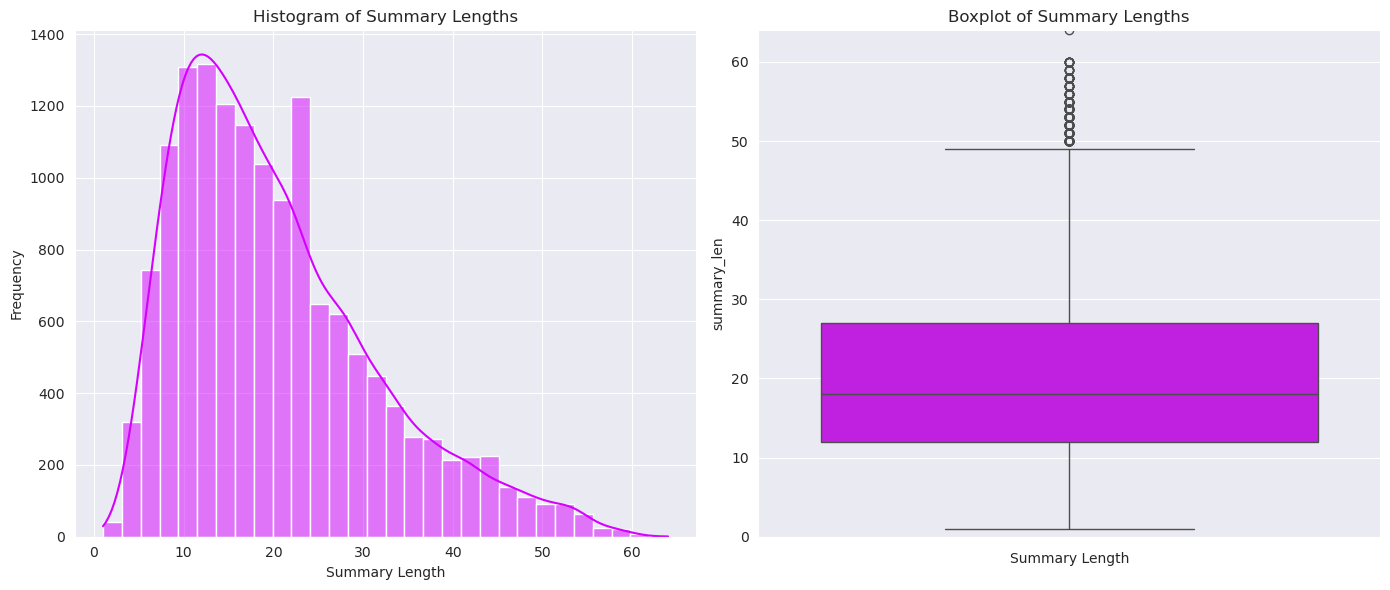

In [8]:
# Define color for the summary plots
summary_color = "#d500ff"

# Summary Length Distribution
plt.figure(figsize=(14, 6))

# Histogram for Summary Lengths
plt.subplot(1, 2, 1)
sns.histplot(train_df['summary_len'], bins=30, kde=True, color=summary_color)
plt.title('Histogram of Summary Lengths')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')

# Boxplot for Summary Lengths
plt.subplot(1, 2, 2)
sns.boxplot(train_df['summary_len'], color=summary_color)
plt.title('Boxplot of Summary Lengths')
plt.xlabel('Summary Length')
# Set y-axis limit to ignore extreme outliers for better visualization
plt.ylim(0, train_df['summary_len'].quantile(1))

plt.tight_layout()
plt.show()


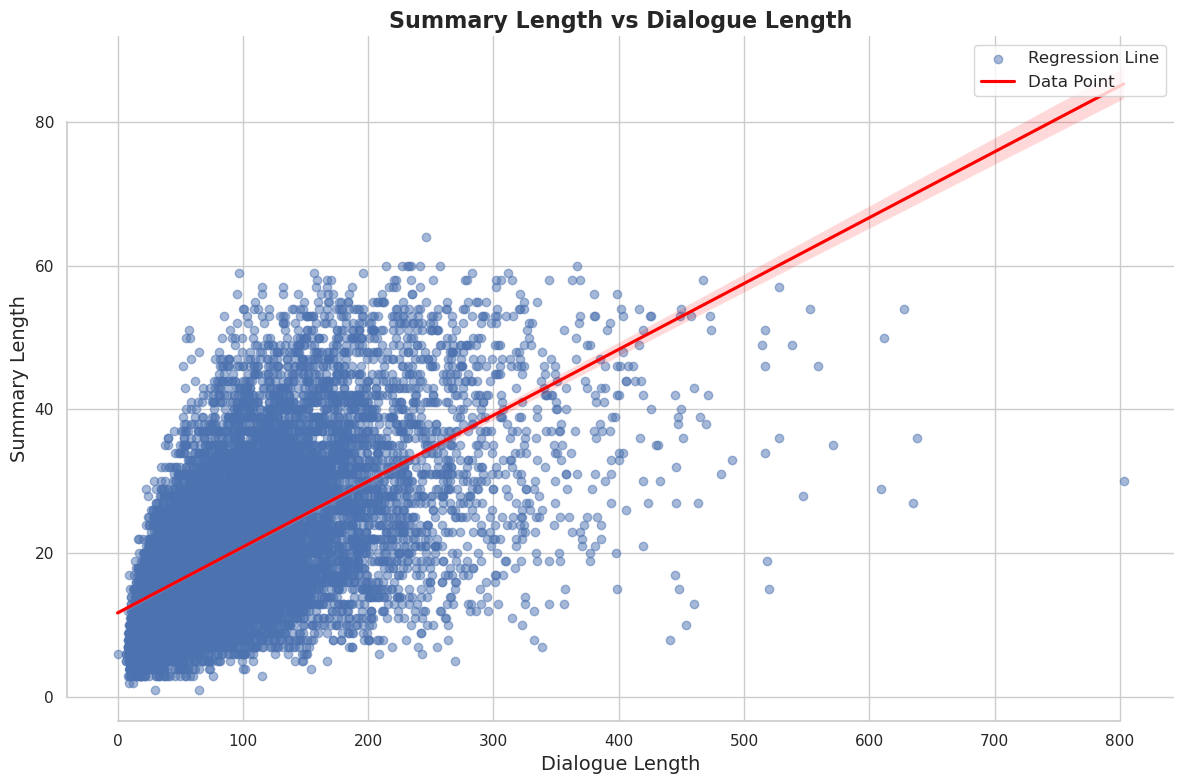

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the scatter plot with a regression line
plt.figure(figsize=(12, 8))
sns.regplot(x=train_df['dialogue_len'], y=train_df['summary_len'], 
            scatter_kws={'alpha':0.5}, line_kws={"color": "red"})

# Add titles and labels with increased font sizes for better readability
plt.title('Summary Length vs Dialogue Length', fontsize=16, fontweight='bold')
plt.xlabel('Dialogue Length', fontsize=14)
plt.ylabel('Summary Length', fontsize=14)

# Add a legend to explain the alpha value
plt.legend(['Regression Line', 'Data Point'], loc='upper right', fontsize=12)

# Enhance aesthetics
sns.despine(trim=True)
plt.tight_layout()

# Show the plot
plt.show()


## Data Preprocessing

In [10]:
train_df.isnull().sum()

id              0
dialogue        0
summary         0
dialogue_len    0
summary_len     0
dtype: int64

In [11]:
print(train_df['dialogue'].iloc[13])

Leon: did you find the job yet?
Arthur: no bro, still unemployed :D
Leon: hahaha, LIVING LIFE
Arthur: i love it, waking up at noon, watching sports - what else could a man want?
Leon: a paycheck? ;)
Arthur: don't be mean... 
Leon: but seriously, my mate has an offer as a junior project manager at his company, are you interested?
Arthur: sure thing, do you have any details?
Leon: <file_photo>
Arthur: that actually looks nice, should I reach out directly to your friend or just apply to this email address from the screenshot?
Leon: it's his email, you can send your resume directly and I will mention to him who you are :)


In [12]:
rows_with_tags_dialogue = train_df['dialogue'].str.contains(r'<.*?>', regex=True, na=False)
rows_with_tags_summary = train_df['summary'].str.contains(r'<.*?>', regex=True, na=False)

count_rows_with_tags_dialogue = rows_with_tags_dialogue.sum()
count_rows_with_tags_summary = rows_with_tags_summary.sum()

print(f"Number of dialogues with tags: {count_rows_with_tags_dialogue}")
print(f"Number of summaries with tags: {count_rows_with_tags_summary}")

#print(train_df[rows_with_tags_dialogue | rows_with_tags_summary])

Number of dialogues with tags: 2663
Number of summaries with tags: 1


In [13]:
import re

def clean_data(text):
    # Remove HTML or XML tags
    clean_text = re.sub(r'<.*?>', '', text)
    
    # Remove empty dialogues
    clean_text = '\n'.join([line for line in clean_text.split('\n') if not re.match('.*:\s*$', line)])

    return clean_text

In [14]:
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: clean_data(str(x)))
train_df['summary'] = train_df['summary'].apply(lambda x: clean_data(str(x)))

In [15]:
print(train_df['dialogue'].iloc[13])

Leon: did you find the job yet?
Arthur: no bro, still unemployed :D
Leon: hahaha, LIVING LIFE
Arthur: i love it, waking up at noon, watching sports - what else could a man want?
Leon: a paycheck? ;)
Arthur: don't be mean... 
Leon: but seriously, my mate has an offer as a junior project manager at his company, are you interested?
Arthur: sure thing, do you have any details?
Arthur: that actually looks nice, should I reach out directly to your friend or just apply to this email address from the screenshot?
Leon: it's his email, you can send your resume directly and I will mention to him who you are :)


In [16]:
val_df['dialogue'] = val_df['dialogue'].apply(lambda x: clean_data(str(x)))
val_df['summary'] = val_df['summary'].apply(lambda x: clean_data(str(x)))

In [17]:
test_df['dialogue'] = test_df['dialogue'].apply(lambda x: clean_data(str(x)))
test_df['summary'] = test_df['summary'].apply(lambda x: clean_data(str(x)))

## Why ROUGE is the Best Metric for Text Summaries

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is widely considered one of the best metrics for evaluating text summaries. This is due to several factors that make it particularly suitable for the task:

### 1. Alignment with Human Judgment
ROUGE scores have been shown to correlate well with human judgments of summary quality. This is critical, as the ultimate goal of summarization is to produce results that humans find useful and accurate.

### 2. Simplicity and Efficiency
The calculation of ROUGE is straightforward, relying on the overlap of n-grams between the system-generated summary and the reference summaries. The simplicity of ROUGE allows for quick and efficient evaluation, enabling rapid testing and development cycles.


### kinds of ROUGE
#### R1: 
R1 measures the overlap of unigrams (individual words) between the system-generated summary and the reference summaries.
#### R2: 
ROUGE-2 measures the overlap of bigrams (pairs of consecutive words) between the system-generated summary and the reference summaries.
#### RL: 
ROUGE-L is based on the longest common subsequence (LCS) between the system-generated summary and the reference summaries.

### Average Scores Considered Good
R1: 0.40+
R2: 0.20+
R3: 0.40+

## Summrizating models examples

## T5

T5, or Text-to-Text Transfer Transformer, is a versatile machine learning model that can perform a variety of natural language processing tasks. For summarization, T5 aims to generate concise and relevant summaries

In [18]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained("t5-large")
tokenizer = T5Tokenizer.from_pretrained("t5-large")

/.autofs/tools/spack/var/spack/environments/psyc681-23083101/.spack-env/view/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:199: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly ha

In [19]:
single_dialogue_data = test_df.loc[50]  # You can choose any index
dialogue = single_dialogue_data['dialogue']
reference_summary = single_dialogue_data['summary']

In [20]:
print(dialogue)
print("-- summary --")
print(reference_summary)
print(len(reference_summary))

Nick: You look absolutely gorgeous and have a lovely smile. 
Nick: Would love to get to know you a bit more. How about we meet up for a drink sometime?
Jane: Hmmm... You're shooting a bit above your range aren't you?
Nick: Why would you think that hon?
Jane: Because I'm not that desperate.
Nick: That was a bit below the belt.
Nick: You're nice but you're not THAT hot.
Jane: Oh is your poor little dick shriveling at the thought?
Nick: Actually I'll take it back. Forget about the drink.
Nick: Forget I ever wrote to you.
Jane: Bye loser!
Nick: Fucking bitch!
Jane: You're welcome!
-- summary --
Nick finds Jane pretty and invites her for a drink to get to know her better. Jane rejects Nick and is unpleasant to him. Nick suggests Jane to forget about their conversation.
176


In [21]:
# Tokenize and generate summary
inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(generated_summary)
print(len(generated_summary))

Jane: oh is your poor little dick shriveling at the thought? nick: actually i'll take it back. forget about the drink. Jane: bye loser!
135


In [22]:
from datasets import load_dataset, load_metric

# Load the ROUGE metric
rouge = load_metric("rouge")

# Compute ROUGE scores
scores = rouge.compute(predictions=[generated_summary], references=[reference_summary])

print("ROUGE-1 Score:", scores["rouge1"].mid.fmeasure)
print("ROUGE-2 Score:", scores["rouge2"].mid.fmeasure)
print("ROUGE-L Score:", scores["rougeL"].mid.fmeasure)

/scratch.local/ipykernel_29806/600188690.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


ROUGE-1 Score: 0.2456140350877193
ROUGE-2 Score: 0.03636363636363637
ROUGE-L Score: 0.17543859649122806


### Bart

BART (Bidirectional and Auto-Regressive Transformers) is a powerful NLP model designed for tasks that require understanding and generating text, such as summarization.

In [23]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the pre-trained BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")


In [24]:
single_dialogue_data = dataset['validation'][0]  # You can choose any index
dialogue = single_dialogue_data['dialogue']
reference_summary = single_dialogue_data['summary']

In [25]:
print(dialogue)
print("-- summary --")
print(reference_summary)
print(len(reference_summary))

A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had to drag him away.
A: He wanted to take it home right away ;-).
B: I wonder what he'll name it.
A: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))
-- summary --
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy. 
143


In [26]:
 # Tokenize and generate summary
inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=300, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(generated_summary)
print(len(generated_summary))

A mother asks her son to take her to an animal shelter to look for a puppy for her son. She wants to get him one of those little dogs that won't grow up too big and eat too much. Her son wanted to take it home right away.
221


In [27]:
# Compute ROUGE scores
scores = rouge.compute(predictions=[generated_summary], references=[reference_summary])

print("ROUGE-1 Score:", scores["rouge1"].mid.fmeasure)
print("ROUGE-2 Score:", scores["rouge2"].mid.fmeasure)
print("ROUGE-L Score:", scores["rougeL"].mid.fmeasure)

ROUGE-1 Score: 0.3333333333333333
ROUGE-2 Score: 0.15789473684210525
ROUGE-L Score: 0.30769230769230765


## Pegasus

PEGASUS (Pre-training with Extracted Gap-sentences for Abstractive Summarization Sequence-to-sequence) is an NLP model optimized for abstractive text summarization. It leverages gap sentences pre-training, where certain sentences are masked and the model is trained to generate these missing parts. This approach enhances its ability to generate more coherent and contextually relevant summaries,

In [28]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Load the pre-trained PEGASUS model and tokenizer
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
single_dialogue_data = dataset['validation'][50]  # You can choose any index
dialogue = single_dialogue_data['dialogue']
reference_summary = single_dialogue_data['summary']

In [30]:
print(dialogue)
print("-- summary --")
print(reference_summary)
print(len(reference_summary))

Rowan: Plans today?
Lilliana: Nothing just waiting to have lunch then maybe have a nap
Rowan: Explain me one thing
Lilliana: What thing?
Rowan: And how is it? Like today u went to work but they sent u back home. U will still get paid for this?
Lilliana: They didn't send me home we decided not to fly and yes I still get paid. I don't get paid hourly I get paid monthly
Rowan: Ok
-- summary --
Liliana is at home and does not have specific plans for the day. Liliana and her colleagues decided not to fly today but she still got paid. Liliana's job pays a fixed rate on a monthly basis.
192


In [31]:
 # Tokenize and generate summary
inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(generated_summary)
print(len(generated_summary))

U will still get paid for this? Lilliana: They didn't send me home we decided not to fly and yes I still get paid. I don't get paid hourly I get paid monthly Rowan: Ok
167


In [32]:
# Compute ROUGE scores
scores = rouge.compute(predictions=[generated_summary], references=[reference_summary])

print("ROUGE-1 Score:", scores["rouge1"].mid.fmeasure)
print("ROUGE-2 Score:", scores["rouge2"].mid.fmeasure)
print("ROUGE-L Score:", scores["rougeL"].mid.fmeasure)

ROUGE-1 Score: 0.26666666666666666
ROUGE-2 Score: 0.08219178082191782
ROUGE-L Score: 0.21333333333333335


## Modeling

In [37]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import datasets
import torch
from tqdm.auto import tqdm

In [38]:
checkpoint = 't5-small'

In [39]:
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
model = T5ForConditionalGeneration.from_pretrained(checkpoint)

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [41]:
from transformers import EvalPrediction

def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred

    # Use only the first item in the predictions tuple (logits)
    logits = predictions[0]

    # Convert logits to token IDs
    predictions = np.argmax(logits, axis=-1)

    # Convert to list of lists
    predictions = predictions.tolist()

    # Decode each prediction individually
    decoded_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(label, pred) for label, pred in zip(decoded_labels, decoded_preds)]

    return {
        "rouge1": np.mean([score['rouge1'].fmeasure for score in rouge_scores]),
        "rouge2": np.mean([score['rouge2'].fmeasure for score in rouge_scores]),
        "rougeL": np.mean([score['rougeL'].fmeasure for score in rouge_scores])
    }


In [42]:
def preprocess_function(examples):
    # Format the input data for T5. Here, we use 'dialogue' as the source and 'summary' as the target.
    inputs = ["summarize: " + doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [43]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./t5-small-finetuned",
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=2,  # Keep batch size small to manage memory
    per_device_eval_batch_size=2,   # Same for evaluation
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps
    learning_rate=2e-5,
    num_train_epochs=4,
    report_to="tensorboard",
    save_strategy="steps",
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True,  # Enable mixed precision training
    optim="adamw_torch",  # Use PyTorch's AdamW optimizer
)


In [44]:
from datasets import Dataset


# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [41]:
# Apply the preprocess function
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

/.autofs/tools/spack/var/spack/environments/psyc681-23083101/.spack-env/view/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

Step,Training Loss,Validation Loss
500,0.537400,0.462720
1000,0.473000,0.437197
1500,0.494400,0.428893
2000,0.484800,0.422478
2500,0.446300,0.417273
3000,0.439200,0.413676
3500,0.448900,0.410376
4000,0.433700,0.407992
4500,0.470200,0.406144
5000,0.415500,0.405728


TrainOutput(global_step=7364, training_loss=0.5164132601440373, metrics={'train_runtime': 1802.4394, 'train_samples_per_second': 32.693, 'train_steps_per_second': 4.086, 'total_flos': 7973256208318464.0, 'train_loss': 0.5164132601440373, 'epoch': 4.0})

### Training Complete

In [31]:
# Saving model so we can reuse it
trainer.save_model()

# Loading saved model

In [45]:
checkpoint = "./t5-small-finetuned"
model = T5ForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

In [46]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## Testing on Validation set

In [33]:
results = trainer.evaluate(val_dataset)
results

{'eval_loss': 0.4030086398124695,
 'eval_rouge1': 0.5667498482765551,
 'eval_rouge2': 0.29234404969926875,
 'eval_rougeL': 0.5306228807663149,
 'eval_runtime': 104.7094,
 'eval_samples_per_second': 7.812,
 'eval_steps_per_second': 0.984}

## Testing the fine-tuned model on test data(unseen)

In [30]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.402781218290329,
 'eval_rouge1': 0.5536519732624882,
 'eval_rouge2': 0.2717633559318934,
 'eval_rougeL': 0.5210078943087978,
 'eval_runtime': 103.9699,
 'eval_samples_per_second': 7.877,
 'eval_steps_per_second': 0.991}

# Testing on the fine-tuned model

In [59]:
single_dialogue_data = test_df.loc[50]  # You can choose any index
dialogue = single_dialogue_data['dialogue']
reference_summary = single_dialogue_data['summary']
print(dialogue)
print("-- summary --")
print(reference_summary)
print(len(reference_summary))

Nick: You look absolutely gorgeous and have a lovely smile. 
Nick: Would love to get to know you a bit more. How about we meet up for a drink sometime?
Jane: Hmmm... You're shooting a bit above your range aren't you?
Nick: Why would you think that hon?
Jane: Because I'm not that desperate.
Nick: That was a bit below the belt.
Nick: You're nice but you're not THAT hot.
Jane: Oh is your poor little dick shriveling at the thought?
Nick: Actually I'll take it back. Forget about the drink.
Nick: Forget I ever wrote to you.
Jane: Bye loser!
Nick: Fucking bitch!
Jane: You're welcome!
-- summary --
Nick finds Jane pretty and invites her for a drink to get to know her better. Jane rejects Nick and is unpleasant to him. Nick suggests Jane to forget about their conversation.
176


In [63]:
# Tokenize and generate summary
inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)

# Move the input tensors to the same device as the model
inputs = inputs.to(model.device)

# Generate summary
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(generated_summary)
print(len(generated_summary))


Nick and Jane are meeting up for a drink. They are shooting a bit above their range. Nick will take it back to Jane's and Jane's shriveling little dick.
152


In [65]:
from datasets import load_dataset, load_metric

# Load the ROUGE metric
rouge = load_metric("rouge")

# Compute ROUGE scores
scores = rouge.compute(predictions=[generated_summary], references=[reference_summary])

print("ROUGE-1 Score:", scores["rouge1"].mid.fmeasure)
print("ROUGE-2 Score:", scores["rouge2"].mid.fmeasure)
print("ROUGE-L Score:", scores["rougeL"].mid.fmeasure)

ROUGE-1 Score: 0.38095238095238093
ROUGE-2 Score: 0.09836065573770492
ROUGE-L Score: 0.28571428571428575


## Fine tuned model testing on 40 examples

###  My model T5 small

In [47]:
from transformers import BartForConditionalGeneration, BartTokenizer
from datasets import load_dataset, load_metric
from sentence_transformers import SentenceTransformer, util
import numpy as np

print("1")
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = "./t5-small-finetuned"
model = T5ForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
# Load the pre-trained BART model and tokenizer
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

print(model)
# Load metrics
rouge = load_metric("rouge")
bleu = load_metric("sacrebleu")
cosine_model = SentenceTransformer('all-MiniLM-L6-v2')

print("2")
model.to(device)


# Select specific range of samples (100 to 140)
sampled_data = test_df.iloc[100:140]

# Initialize metrics
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
bleu_scores = []
cosine_scores = []

print("3")
for index, row in sampled_data.iterrows():
    dialogue = row['dialogue']
    reference_summary = row['summary']

    # Tokenize and generate summary
    inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(model.device)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Compute ROUGE and BLEU scores
    rouge_score = rouge.compute(predictions=[generated_summary], references=[reference_summary])
    bleu_score = bleu.compute(predictions=[generated_summary], references=[[reference_summary]])

    # Compute Cosine Similarity
    embedding1 = cosine_model.encode(generated_summary, convert_to_tensor=True)
    embedding2 = cosine_model.encode(reference_summary, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()

    # Append scores
    for key in rouge_scores:
        rouge_scores[key].append(rouge_score[key].mid.fmeasure)
    bleu_scores.append(bleu_score["score"])
    cosine_scores.append(cosine_score)

print("5")
# Calculate average scores
average_rouge_scores = {key: np.mean(values) for key, values in rouge_scores.items()}
average_bleu_score = np.mean(bleu_scores)
average_cosine_score = np.mean(cosine_scores)

print("Average ROUGE-1 Score:", average_rouge_scores["rouge1"])
print("Average ROUGE-2 Score:", average_rouge_scores["rouge2"])
print("Average ROUGE-L Score:", average_rouge_scores["rougeL"])
print("Average BLEU Score:", average_bleu_score)
print("Average Cosine Similarity Score:", average_cosine_score)



1
T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dr

## T5 large

In [21]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset, load_metric
from sentence_transformers import SentenceTransformer, util
import numpy as np

print("1")
device = "cuda" if torch.cuda.is_available() else "cpu"

model = T5ForConditionalGeneration.from_pretrained("t5-large")
tokenizer = T5Tokenizer.from_pretrained("t5-large")

# Load metrics
rouge = load_metric("rouge")
bleu = load_metric("sacrebleu")
cosine_model = SentenceTransformer('all-MiniLM-L6-v2')

print("2")
model.to(device)


# Select specific range of samples (100 to 140)
sampled_data = test_df.iloc[100:140]

# Initialize metrics
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
bleu_scores = []
cosine_scores = []

print("3")
for index, row in sampled_data.iterrows():
    dialogue = row['dialogue']
    reference_summary = row['summary']

    # Tokenize and generate summary
    inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(model.device)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Compute ROUGE and BLEU scores
    rouge_score = rouge.compute(predictions=[generated_summary], references=[reference_summary])
    bleu_score = bleu.compute(predictions=[generated_summary], references=[[reference_summary]])

    # Compute Cosine Similarity
    embedding1 = cosine_model.encode(generated_summary, convert_to_tensor=True)
    embedding2 = cosine_model.encode(reference_summary, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()

    # Append scores
    for key in rouge_scores:
        rouge_scores[key].append(rouge_score[key].mid.fmeasure)
    bleu_scores.append(bleu_score["score"])
    cosine_scores.append(cosine_score)

print("5")
# Calculate average scores
average_rouge_scores = {key: np.mean(values) for key, values in rouge_scores.items()}
average_bleu_score = np.mean(bleu_scores)
average_cosine_score = np.mean(cosine_scores)

print("Average ROUGE-1 Score:", average_rouge_scores["rouge1"])
print("Average ROUGE-2 Score:", average_rouge_scores["rouge2"])
print("Average ROUGE-L Score:", average_rouge_scores["rougeL"])
print("Average BLEU Score:", average_bleu_score)
print("Average Cosine Similarity Score:", average_cosine_score)



1


/.autofs/tools/spack/var/spack/environments/psyc681-23083101/.spack-env/view/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:199: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


2
3
5
Average ROUGE-1 Score: 0.3045216032847896
Average ROUGE-2 Score: 0.09597678560590912
Average ROUGE-L Score: 0.23152501425298952
Average BLEU Score: 4.82319837979074
Average Cosine Similarity Score: 0.6744917120784522


## Bart Large

In [34]:
from transformers import BartForConditionalGeneration, BartTokenizer
from datasets import load_dataset, load_metric
from sentence_transformers import SentenceTransformer, util
import numpy as np

print("1")
device = "cuda" if torch.cuda.is_available() else "cpu"


# Load the pre-trained BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")


# Load metrics
rouge = load_metric("rouge")
bleu = load_metric("sacrebleu")
cosine_model = SentenceTransformer('all-MiniLM-L6-v2')

print("2")
model.to(device)


# Select specific range of samples (100 to 140)
sampled_data = test_df.iloc[100:140]

# Initialize metrics
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
bleu_scores = []
cosine_scores = []

print("3")
for index, row in sampled_data.iterrows():
    dialogue = row['dialogue']
    reference_summary = row['summary']

    # Tokenize and generate summary
    inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(model.device)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Compute ROUGE and BLEU scores
    rouge_score = rouge.compute(predictions=[generated_summary], references=[reference_summary])
    bleu_score = bleu.compute(predictions=[generated_summary], references=[[reference_summary]])

    # Compute Cosine Similarity
    embedding1 = cosine_model.encode(generated_summary, convert_to_tensor=True)
    embedding2 = cosine_model.encode(reference_summary, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()

    # Append scores
    for key in rouge_scores:
        rouge_scores[key].append(rouge_score[key].mid.fmeasure)
    bleu_scores.append(bleu_score["score"])
    cosine_scores.append(cosine_score)

print("5")
# Calculate average scores
average_rouge_scores = {key: np.mean(values) for key, values in rouge_scores.items()}
average_bleu_score = np.mean(bleu_scores)
average_cosine_score = np.mean(cosine_scores)

print("Average ROUGE-1 Score:", average_rouge_scores["rouge1"])
print("Average ROUGE-2 Score:", average_rouge_scores["rouge2"])
print("Average ROUGE-L Score:", average_rouge_scores["rougeL"])
print("Average BLEU Score:", average_bleu_score)
print("Average Cosine Similarity Score:", average_cosine_score)



1
2
3
5
Average ROUGE-1 Score: 0.31892382634372307
Average ROUGE-2 Score: 0.09894151842259975
Average ROUGE-L Score: 0.23520744072613392
Average BLEU Score: 6.278914532228085
Average Cosine Similarity Score: 0.6961218930780888


## pegasus Large

In [48]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from datasets import load_dataset, load_metric
from sentence_transformers import SentenceTransformer, util
import numpy as np

print("1")
device = "cuda" if torch.cuda.is_available() else "cpu"


# Load the pre-trained BART model and tokenizer
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")


# Load metrics
rouge = load_metric("rouge")
bleu = load_metric("sacrebleu")
cosine_model = SentenceTransformer('all-MiniLM-L6-v2')

print("2")
model.to(device)


# Select specific range of samples (100 to 140)
sampled_data = test_df.iloc[100:140]

# Initialize metrics
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
bleu_scores = []
cosine_scores = []

print("3")
for index, row in sampled_data.iterrows():
    dialogue = row['dialogue']
    reference_summary = row['summary']

    # Tokenize and generate summary
    inputs = tokenizer.encode("summarize: " + dialogue, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(model.device)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Compute ROUGE and BLEU scores
    rouge_score = rouge.compute(predictions=[generated_summary], references=[reference_summary])
    bleu_score = bleu.compute(predictions=[generated_summary], references=[[reference_summary]])

    # Compute Cosine Similarity
    embedding1 = cosine_model.encode(generated_summary, convert_to_tensor=True)
    embedding2 = cosine_model.encode(reference_summary, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()

    # Append scores
    for key in rouge_scores:
        rouge_scores[key].append(rouge_score[key].mid.fmeasure)
    bleu_scores.append(bleu_score["score"])
    cosine_scores.append(cosine_score)

print("5")
# Calculate average scores
average_rouge_scores = {key: np.mean(values) for key, values in rouge_scores.items()}
average_bleu_score = np.mean(bleu_scores)
average_cosine_score = np.mean(cosine_scores)

print("Average ROUGE-1 Score:", average_rouge_scores["rouge1"])
print("Average ROUGE-2 Score:", average_rouge_scores["rouge2"])
print("Average ROUGE-L Score:", average_rouge_scores["rougeL"])
print("Average BLEU Score:", average_bleu_score)
print("Average Cosine Similarity Score:", average_cosine_score)



1


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2
3
5
Average ROUGE-1 Score: 0.2701661171389088
Average ROUGE-2 Score: 0.07027872375457671
Average ROUGE-L Score: 0.20928375869022026
Average BLEU Score: 3.8818164942664666
Average Cosine Similarity Score: 0.6431989915668964


### ploting results

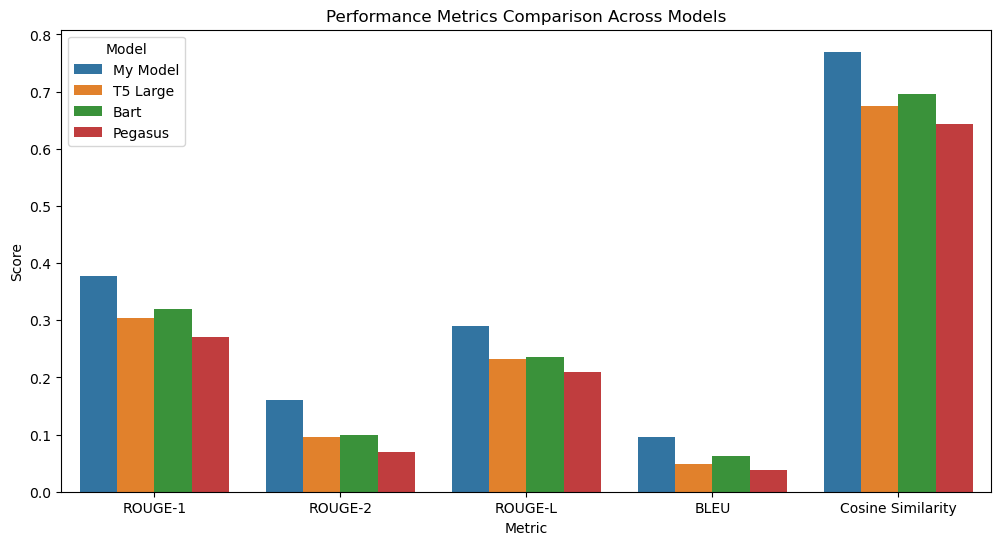

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the four models
data = {
    'Model': ['My Model', 'T5 Large', 'Bart', 'Pegasus'],
    'ROUGE-1': [0.3767, 0.3045, 0.3189, 0.2702],
    'ROUGE-2': [0.1596, 0.0960, 0.0989, 0.0703],
    'ROUGE-L': [0.2896, 0.2315, 0.2352, 0.2093],
    'BLEU': [9.5236, 4.8232, 6.2789, 3.8818],
    'Cosine Similarity': [0.7698, 0.6745, 0.6961, 0.6432]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Normalize the BLEU scores to be between 0 and 1 (as they are out of 100)
df['BLEU'] = df['BLEU'] / 100
# Preparing data for a combined bar plot
df_melted = pd.melt(df, id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title('Performance Metrics Comparison Across Models')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model', loc='upper left')
plt.show()



## Conclusion 

The results of this study, particularly the analysis of 40 samples from the test set, highlight the impressive performance of the fine-tuned T5-small model in comparison to its larger counterparts. This is not only a significant finding in terms of model efficiency but also in the potential for smaller models to achieve high-quality text summarization.